**README**

This was run and worked in 80539c72bdc966e52b80c15ef93cc6498cc720ed

Ignore the text comments in the notebook below, they are from the debugging phase and I could not be bothered to clean-up

In [1]:
import torch
from math import pi,sqrt,log,e,exp
from time import time
from matplotlib import pyplot
import numpy as np
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm
device = torch.device("cuda:7")

from src.training.weighted_dataset.dkl_training import BasicStatefulDKLTrainer
from src.training.weighted_dataset.variance_training import BasicStatefulVarTrainer
from src.models.flows.sequential import InvertibleSequentialFlow
from src.models.flows.coupling_cells.real_nvp import RealNVP
from src.models.flows.coupling_cells.piecewise_coupling.piecewise_linear import PWLinearCoupling
from src.models.flows.sampling import UniformSampler,FactorizedGaussianSampler
from src.models.flows.analytic_flows.element_wise import InvertibleAnalyticSigmoid
from src.integration.flat_survey_integrator import FlatSurveySamplingIntegrator
from src.integration.dkltrainer_integrator import DKLAdaptiveSurveyIntegrator
from src import setup_std_stream_logger

setup_std_stream_logger(debug=True)

# Debugging the DKL training

In [2]:
posterior=UniformSampler(d=2,low=0.,high=1.,device=device)
prior=UniformSampler(d=2,low=0.,high=1.,device=device)

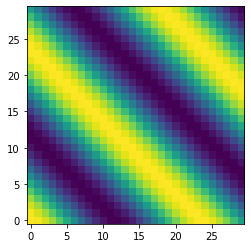

In [3]:
# a function with a small amplitude and no zero

def nonzerocos(x):
    return 1+torch.cos(4*(x[:,0]+x[:,1]))**2

n = 30
plt.imshow(nonzerocos(torch.cartesian_prod(torch.arange(0,1,1/n),torch.arange(0,1,1/n))).reshape(n,n).numpy(),origin="lower")
plt.show()

In [4]:
# We add a layer for the neural net that maps the unit hypercube to -1,1

class Reshift(torch.nn.Module):
    def forward(self,x):
        return (x-0.5)*2.

In [5]:
model  = InvertibleSequentialFlow(2,[
        PWLinearCoupling(d=2,
              mask=[True,False],
              d_hidden=256,
              n_hidden=8,
              n_bins=32,
              hidden_activation=torch.nn.LeakyReLU,
              #input_activation=Reshift,
              use_batch_norm=False).to(device),
        PWLinearCoupling(d=2,
              mask=[False,True],
              d_hidden=256,
              n_hidden=8,
              n_bins=32,
              hidden_activation=torch.nn.LeakyReLU,
              #input_activation=Reshift,
              use_batch_norm=False).to(device), 
])

trainer = BasicStatefulDKLTrainer(flow=model,latent_prior=prior)


optim = torch.optim.Adam(model.parameters(),lr=1.e-3)

trainer.set_config(n_epochs=30, minibatch_size=20000, optim=optim)

integrator=FlatSurveySamplingIntegrator(nonzerocos,trainer,2,device=device, verbosity=3, trainer_verbosity=3)

In [6]:
result=integrator.integrate(8,1)

Starting integration
Initializing the survey phase
Starting the survey phase
Training on batch: 100000 points
Epoch 1/30
Loss: 1.961e-03
Loss: 1.029e-03
Loss: 2.378e-04
Loss: -1.047e-03
Loss: -3.290e-04
Epoch 2/30
Loss: -3.480e-03
Loss: -2.649e-03
Loss: -2.328e-03
Loss: -3.129e-03
Loss: -2.191e-03
Epoch 3/30
Loss: -3.740e-03
Loss: -3.254e-03
Loss: -3.457e-03
Loss: -4.399e-03
Loss: -3.520e-03
Epoch 4/30
Loss: -4.434e-03
Loss: -4.541e-03
Loss: -5.574e-03
Loss: -8.852e-03
Loss: -6.646e-03
Epoch 5/30
Loss: -1.029e-02
Loss: -9.403e-03
Loss: -1.094e-02
Loss: -1.702e-02
Loss: -1.720e-02
Epoch 6/30
Loss: -2.068e-02
Loss: -1.976e-02
Loss: -2.087e-02
Loss: -2.513e-02
Loss: -2.406e-02
Epoch 7/30
Loss: -2.767e-02
Loss: -2.517e-02
Loss: -2.557e-02
Loss: -3.137e-02
Loss: -3.039e-02
Epoch 8/30
Loss: -3.230e-02
Loss: -3.097e-02
Loss: -3.144e-02
Loss: -3.772e-02
Loss: -3.638e-02
Epoch 9/30
Loss: -3.550e-02
Loss: -3.410e-02
Loss: -3.604e-02
Loss: -4.012e-02
Loss: -3.921e-02
Epoch 10/30
Loss: -4.042e-02


Loss: -4.441e-02
Loss: -4.776e-02
Loss: -4.488e-02
Loss: -4.453e-02
Epoch 24/30
Loss: -4.390e-02
Loss: -4.507e-02
Loss: -4.758e-02
Loss: -4.432e-02
Loss: -4.498e-02
Epoch 25/30
Loss: -4.412e-02
Loss: -4.427e-02
Loss: -4.801e-02
Loss: -4.461e-02
Loss: -4.488e-02
Epoch 26/30
Loss: -4.465e-02
Loss: -4.438e-02
Loss: -4.784e-02
Loss: -4.508e-02
Loss: -4.482e-02
Epoch 27/30
Loss: -4.401e-02
Loss: -4.479e-02
Loss: -4.809e-02
Loss: -4.476e-02
Loss: -4.470e-02
Epoch 28/30
Loss: -4.412e-02
Loss: -4.486e-02
Loss: -4.791e-02
Loss: -4.501e-02
Loss: -4.487e-02
Epoch 29/30
Loss: -4.446e-02
Loss: -4.479e-02
Loss: -4.853e-02
Loss: -4.503e-02
Loss: -4.525e-02
Epoch 30/30
Loss: -4.516e-02
Loss: -4.479e-02
Loss: -4.821e-02
Loss: -4.552e-02
Loss: -4.524e-02
Integral: 1.498e+00 +/- 1.109e-03
Training on batch: 100000 points
Epoch 1/30
Loss: -3.987e-02
Loss: -3.755e-02
Loss: -3.521e-02
Loss: -4.083e-02
Loss: -3.614e-02
Epoch 2/30
Loss: -4.345e-02
Loss: -3.917e-02
Loss: -3.915e-02
Loss: -4.376e-02
Loss: -3.82

Epoch 16/30
Loss: -4.476e-02
Loss: -4.539e-02
Loss: -4.730e-02
Loss: -4.434e-02
Loss: -4.141e-02
Epoch 17/30
Loss: -4.539e-02
Loss: -4.514e-02
Loss: -4.734e-02
Loss: -4.446e-02
Loss: -4.153e-02
Epoch 18/30
Loss: -4.522e-02
Loss: -4.532e-02
Loss: -4.751e-02
Loss: -4.433e-02
Loss: -4.190e-02
Epoch 19/30
Loss: -4.449e-02
Loss: -4.595e-02
Loss: -4.715e-02
Loss: -4.383e-02
Loss: -4.196e-02
Epoch 20/30
Loss: -4.406e-02
Loss: -4.606e-02
Loss: -4.695e-02
Loss: -4.394e-02
Loss: -4.170e-02
Epoch 21/30
Loss: -4.418e-02
Loss: -4.600e-02
Loss: -4.687e-02
Loss: -4.414e-02
Loss: -4.121e-02
Epoch 22/30
Loss: -4.531e-02
Loss: -4.599e-02
Loss: -4.648e-02
Loss: -4.461e-02
Loss: -4.159e-02
Epoch 23/30
Loss: -4.514e-02
Loss: -4.626e-02
Loss: -4.707e-02
Loss: -4.409e-02
Loss: -4.246e-02
Epoch 24/30
Loss: -4.524e-02
Loss: -4.480e-02
Loss: -4.804e-02
Loss: -4.404e-02
Loss: -4.139e-02
Epoch 25/30
Loss: -4.518e-02
Loss: -4.522e-02
Loss: -4.745e-02
Loss: -4.435e-02
Loss: -4.189e-02
Epoch 26/30
Loss: -4.485e-02
L

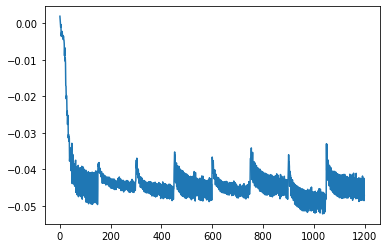

In [7]:
losses = []
for r in result[2].dropna()["training record"]:
    losses+=r["metrics"]["loss"]
plt.plot(losses)
plt.show()

1.4970433712005615 0.35123630861837624


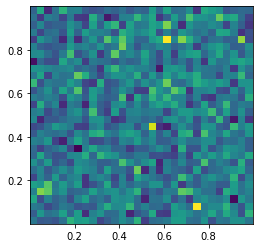

In [8]:
x,px,fx = integrator.sample_survey()
var,mean = torch.var_mean(fx/px)
print(mean.item(),sqrt(var))
fig, ax = plt.subplots()
fig.set_size_inches((4,4))
n=30
h1=ax.hist2d(x[:,0].cpu().numpy(),x[:,1].cpu().numpy(),bins=n)
plt.show()

1.4976704120635986 0.120720754187831


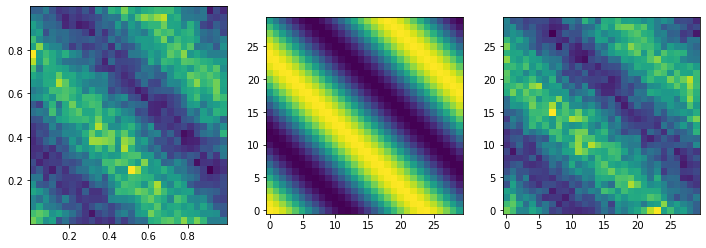

In [9]:
x,px,fx=integrator.sample_refine(n_points=100000)
var,mean = torch.var_mean(fx/px)
print(mean.item(),sqrt(var))
fig, axs = plt.subplots(1,3)
fig.set_size_inches((12,4))
n=30
h2=axs[0].hist2d(x[:,0].cpu().numpy(),x[:,1].cpu().numpy(),bins=n)
axs[1].imshow(nonzerocos(torch.cartesian_prod(torch.arange(0,1,1/n),torch.arange(0,1,1/n))).reshape(n,n).numpy(),origin="lower",)
axs[2].imshow(h2[0],origin="lower")
plt.show()

In [10]:
func_sample = nonzerocos(torch.cartesian_prod(torch.arange(0,1,1/n),torch.arange(0,1,1/n))).reshape(n,n).numpy()

In [11]:
fn = func_sample/np.sum(func_sample)
h1n = h1[0]/np.sum(h1[0])
h2n = h2[0]/np.sum(h2[0])
print((fn/h1n).var())
print((fn/h2n).var())

0.06654291546787666
0.01711491027677318


Quite annoying: the function has visibly been learned, the DKL has significantly decreased but the variance is actually worse!!

In [12]:
del model, trainer, integrator, x , px ,fx, optim

### making checks more systematic

In [13]:
def test_func(f, epochs=10, n_survey=1):
    model  = InvertibleSequentialFlow(2,[
        PWLinearCoupling(d=2,
              mask=[True,False],
              d_hidden=128,
              n_hidden=8,
              n_bins=30,
              hidden_activation=torch.nn.LeakyReLU,
              input_activation=Reshift,
              use_batch_norm=False).to(device),
        PWLinearCoupling(d=2,
              mask=[False,True],
              d_hidden=128,
              n_hidden=8,
              n_bins=30,
              hidden_activation=torch.nn.LeakyReLU,
              input_activation=Reshift,
              use_batch_norm=False).to(device),
])

    trainer = BasicStatefulDKLTrainer(flow=model,latent_prior=prior)


    optim = torch.optim.Adam(model.parameters(),lr=1.e-3)

    trainer.set_config(n_epochs=epochs, minibatch_size=20000, optim=optim)

    integrator=FlatSurveySamplingIntegrator(f,trainer,2,device=device, verbosity=1, trainer_verbosity=0)
    
    result=integrator.integrate(n_survey,1)
    losses = []
    for r in result[2].dropna()["training record"]:
        losses+=r["metrics"]["loss"]
    plt.plot(losses)
    plt.show()
    
    x,px,fx = integrator.sample_survey()
    varf,meanf = torch.var_mean(fx/px)
    print(f"flat: {meanf} with var {varf}")
    x,px,fx = integrator.sample_refine()
    var,mean = torch.var_mean(fx/px)
    print(f"model: {mean} with var {var}")
    print(f"speed-up: {varf/var}")
    print("\n")

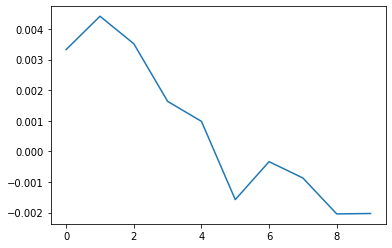

flat: 1.4961233139038086 with var 0.1230255737900734
model: 1.4981799125671387 with var 0.11779672652482986
speed-up: 1.044388771057129




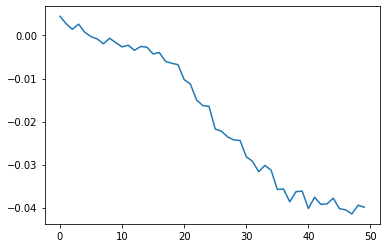

flat: 1.4959710836410522 with var 0.12288098782300949
model: 1.4976508617401123 with var 0.01063053123652935
speed-up: 11.55925178527832




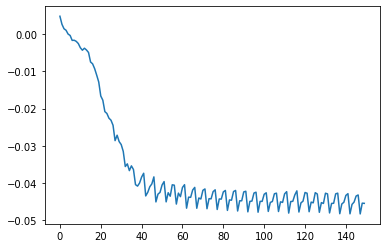

flat: 1.497359275817871 with var 0.12291350215673447
model: 1.4976108074188232 with var 0.009243200533092022
speed-up: 13.297720909118652




In [14]:
# Checking: there's a sweet spot: if we train the DKL too much we make things worse
test_func(nonzerocos,2,1)
test_func(nonzerocos,10,1)
test_func(nonzerocos,30,1)

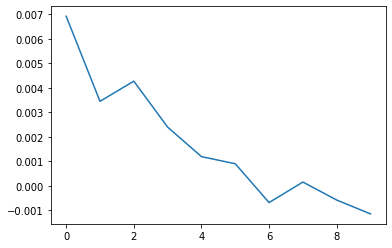

flat: 1.4947541952133179 with var 0.12332261353731155
model: 1.4965708255767822 with var 0.11786270141601562
speed-up: 1.046324372291565




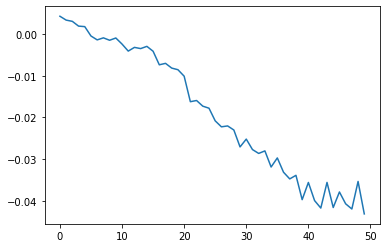

flat: 1.4990434646606445 with var 0.12295808643102646
model: 1.4974050521850586 with var 0.012981888838112354
speed-up: 9.47150993347168




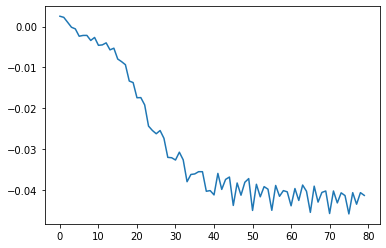

flat: 1.4990140199661255 with var 0.12312312424182892
model: 1.497698426246643 with var 0.007202391978353262
speed-up: 17.094755172729492




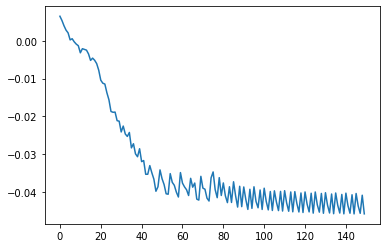

flat: 1.4972951412200928 with var 0.12318786233663559
model: 1.4973663091659546 with var 0.008007977157831192
speed-up: 15.383143424987793




In [15]:
# Could it be overfitting? Not so far
test_func(nonzerocos,1,2)
test_func(nonzerocos,5,2)
test_func(nonzerocos,8,2)
test_func(nonzerocos,15,2)

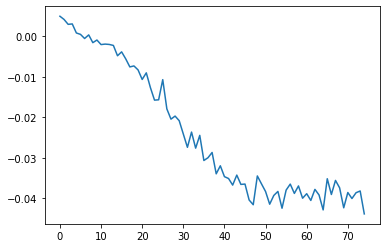

flat: 1.4970359802246094 with var 0.12265092134475708
model: 1.4977695941925049 with var 0.005587829742580652
speed-up: 21.94965171813965




In [16]:
# More aggressive attempt: slightly better
test_func(nonzerocos,1,15)

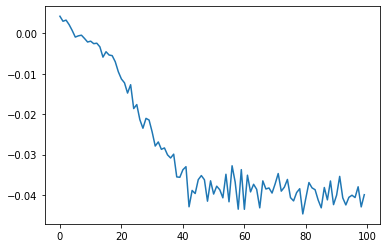

flat: 1.4976825714111328 with var 0.12350417673587799
model: 1.497032880783081 with var 0.004751534201204777
speed-up: 25.992483139038086




In [17]:
# More aggressive attempt: still ends up not good
test_func(nonzerocos,1,20)

# Is this an issue with the DKL?

In [18]:
def test_func_var(f, epochs=10, n_survey=1, show_sample=False, lr=1.e-3):
    model  = InvertibleSequentialFlow(2,[
        PWLinearCoupling(d=2,
              mask=[True,False],
              d_hidden=128,
              n_hidden=8,
              n_bins=30,
              hidden_activation=torch.nn.LeakyReLU,
              input_activation=Reshift,
              use_batch_norm=False).to(device),
        PWLinearCoupling(d=2,
              mask=[False,True],
              d_hidden=128,
              n_hidden=8,
              n_bins=30,
              hidden_activation=torch.nn.LeakyReLU,
              input_activation=Reshift,
              use_batch_norm=False).to(device),
])

    trainer = BasicStatefulVarTrainer(flow=model,latent_prior=prior)


    optim = torch.optim.Adam(model.parameters(),lr=lr)

    trainer.set_config(n_epochs=epochs, minibatch_size=20000, optim=optim)

    integrator=FlatSurveySamplingIntegrator(f,trainer,2,device=device, verbosity=1, trainer_verbosity=0)
    
    result=integrator.integrate(n_survey,1)
    losses = []
    for r in result[2].dropna()["training record"]:
        losses+=r["metrics"]["loss"]
    plt.plot(losses)
    plt.show()
    
    x,px,fx = integrator.sample_survey()
    varf,meanf = torch.var_mean(fx/px)
    print(f"flat: {meanf} with var {varf}")
    x,px,fx = integrator.sample_refine()
    var,mean = torch.var_mean(fx/px)
    print(f"model: {mean} with var {var}")
    print(f"speed-up: {varf/var}")
    print("\n")
    
    if show_sample:
        x,px,fx=integrator.sample_refine(n_points=100000)
        fig, axs = plt.subplots(1,3)
        fig.set_size_inches((12,4))
        n=30
        h2=axs[0].hist2d(x[:,0].cpu().numpy(),x[:,1].cpu().numpy(),bins=n)
        axs[1].imshow(f(torch.cartesian_prod(torch.arange(0,1,1/n),torch.arange(0,1,1/n))).reshape(n,n).numpy(),origin="lower",)
        axs[2].imshow(h2[0],origin="lower")
        plt.show()
        
    return varf/var

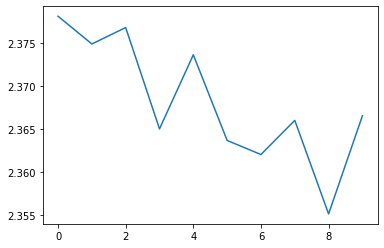

flat: 1.4969675540924072 with var 0.12305706739425659
model: 1.4969747066497803 with var 0.11450771987438202
speed-up: 1.0746617317199707




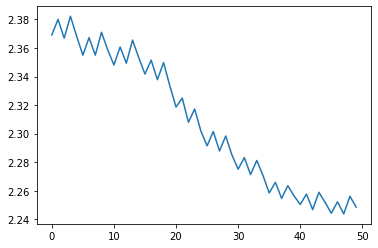

flat: 1.497622013092041 with var 0.12285646051168442
model: 1.4973945617675781 with var 0.007043417543172836
speed-up: 17.442733764648438




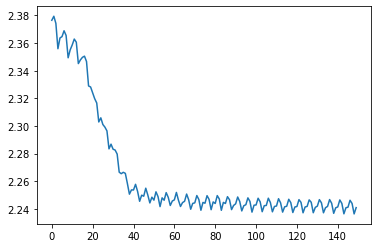

flat: 1.4958579540252686 with var 0.12316875159740448
model: 1.4975624084472656 with var 0.003147823503240943
speed-up: 39.12822723388672




tensor(39.1282, device='cuda:7')

In [19]:
test_func_var(nonzerocos,2,1)
test_func_var(nonzerocos,10,1)
test_func_var(nonzerocos,30,1)

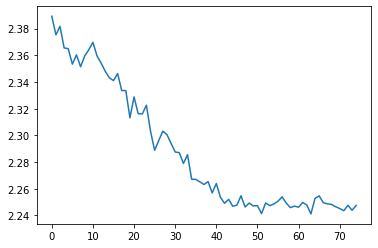

flat: 1.4953243732452393 with var 0.12256931513547897
model: 1.4974582195281982 with var 0.003764223074540496
speed-up: 32.561649322509766




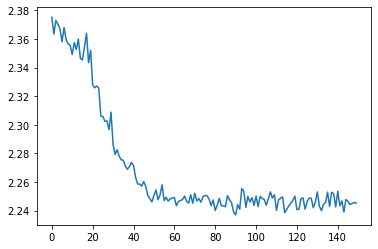

flat: 1.496535301208496 with var 0.12338757514953613
model: 1.497191071510315 with var 0.00305926357395947
speed-up: 40.33244323730469




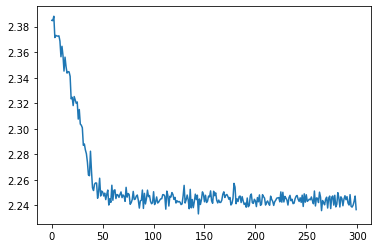

flat: 1.4971415996551514 with var 0.12282592803239822
model: 1.4975130558013916 with var 0.001956830034032464
speed-up: 62.76780700683594




tensor(62.7678, device='cuda:7')

In [20]:
test_func_var(nonzerocos,1,15)
test_func_var(nonzerocos,1,30)
test_func_var(nonzerocos,1,60)

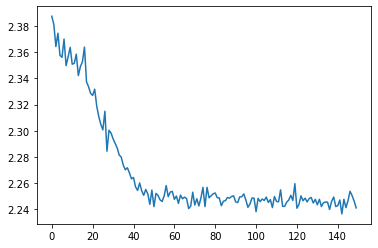

flat: 1.4976634979248047 with var 0.12268660962581635
model: 1.4974232912063599 with var 0.003238153411075473
speed-up: 37.88783264160156




tensor(37.8878, device='cuda:7')

In [21]:
test_func_var(nonzerocos,1,30)

OK so it's clearly much better with the variance loss than the DKL loss to optimize the variance. Interesting because they have the same minimum but probably approaching it in a less ideal direction?

Let's try to validate with other functions

## Same function but actually goes to 0

In [22]:
def poscos(x):
    return torch.cos(4*(x[:,0]+x[:,1]))**2

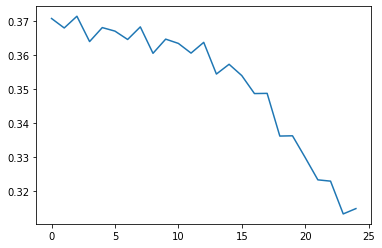

flat: 0.49734973907470703 with var 0.12286321818828583
model: 0.49770259857177734 with var 0.06597048789262772
speed-up: 1.8623967170715332




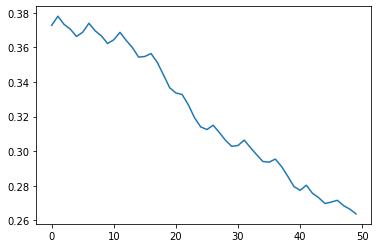

flat: 0.49877315759658813 with var 0.12263639271259308
model: 0.4974784255027771 with var 0.01719111017882824
speed-up: 7.133709907531738




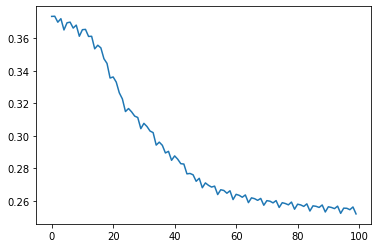

flat: 0.4969313144683838 with var 0.12319622188806534
model: 0.49733442068099976 with var 0.006541873328387737
speed-up: 18.83194923400879




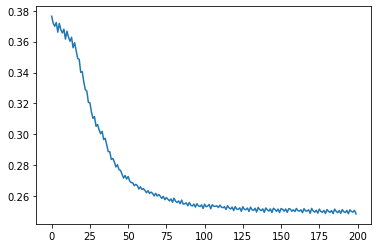

flat: 0.4975380003452301 with var 0.12335257232189178
model: 0.49731510877609253 with var 0.003625974291935563
speed-up: 34.0191535949707




tensor(34.0192, device='cuda:7')

In [23]:
test_func_var(poscos,5,1,False)
test_func_var(poscos,10,1,False)
test_func_var(poscos,20,1,False)
test_func_var(poscos,40,1,False)

There seems to be a sweet spot with a single sample set. Let's go overboard the other way

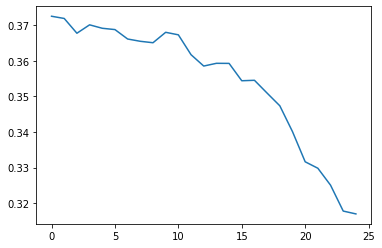

flat: 0.4980396330356598 with var 0.1232273131608963
model: 0.49872010946273804 with var 0.06588348746299744
speed-up: 1.870382308959961




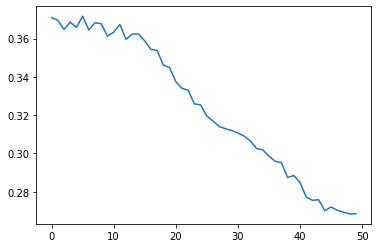

flat: 0.4979012906551361 with var 0.12313302606344223
model: 0.49742230772972107 with var 0.019216032698750496
speed-up: 6.407827854156494




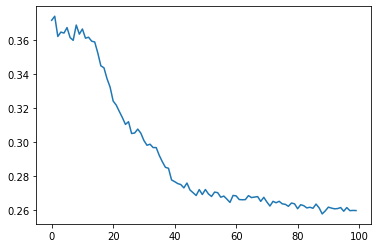

flat: 0.49645960330963135 with var 0.12350478023290634
model: 0.4970378279685974 with var 0.011041618883609772
speed-up: 11.185386657714844




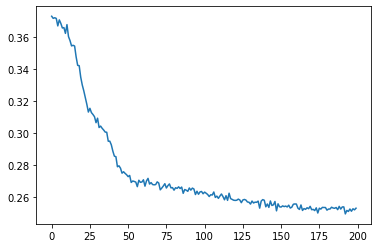

flat: 0.49890798330307007 with var 0.12311677634716034
model: 0.4974697232246399 with var 0.004691526293754578
speed-up: 26.242372512817383




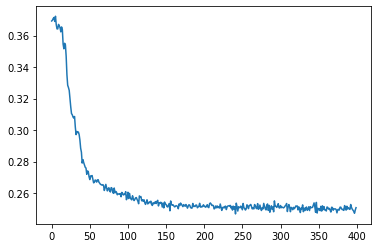

flat: 0.4949693977832794 with var 0.123398557305336
model: 0.49769341945648193 with var 0.0027301597874611616
speed-up: 45.19829177856445




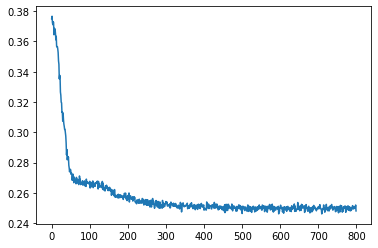

flat: 0.49755364656448364 with var 0.12349078804254532
model: 0.4974934458732605 with var 0.0022656286600977182
speed-up: 54.50619125366211




tensor(54.5062, device='cuda:7')

In [24]:
test_func_var(poscos,1,5,False)
test_func_var(poscos,1,10,False)
test_func_var(poscos,1,20,False)
test_func_var(poscos,1,40,False)
test_func_var(poscos,1,80,False)
test_func_var(poscos,1,160,False)

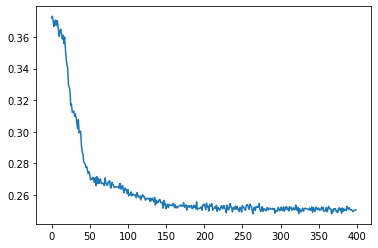

flat: 0.49768221378326416 with var 0.12308946996927261
model: 0.4971861243247986 with var 0.0027342962566763163
speed-up: 45.01687240600586




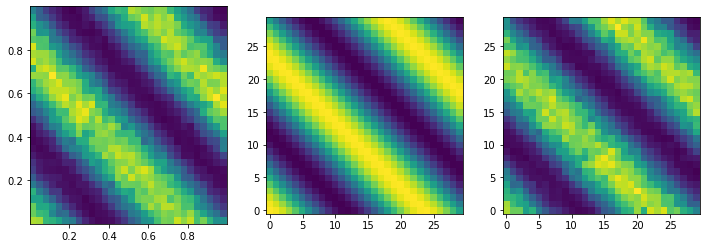

tensor(45.0169, device='cuda:7')

In [25]:
test_func_var(poscos,1,80,True)

## Camel function

In [26]:
def camel(x):
    return torch.exp(- torch.sum(((x-.25)/0.1)**2,dim=-1)  )+torch.exp(- torch.sum(((x-.75)/0.1)**2,dim=-1)  )

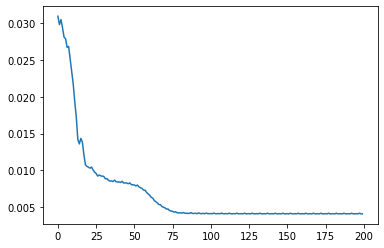

flat: 0.06260377168655396 with var 0.027380313724279404
model: 0.06272329390048981 with var 0.00015052271191962063
speed-up: 181.90155029296875




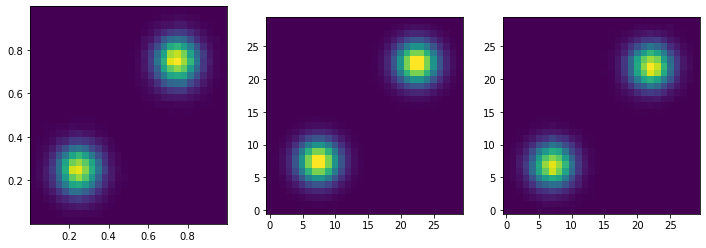

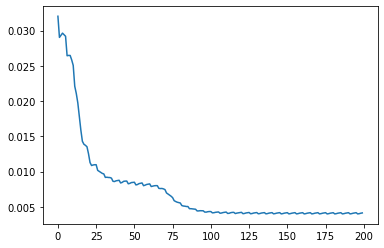

flat: 0.06293486803770065 with var 0.027541982010006905
model: 0.06290332973003387 with var 0.0001193498756038025
speed-up: 230.76673889160156




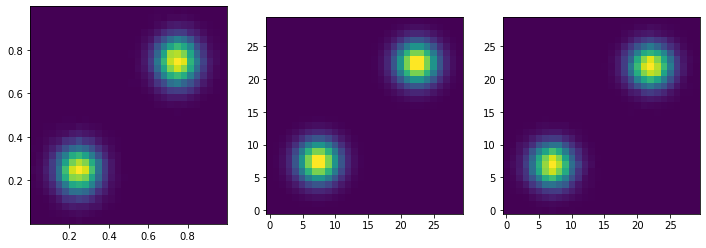

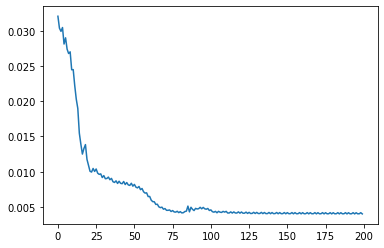

flat: 0.06317892670631409 with var 0.027733324095606804
model: 0.06284043937921524 with var 0.00016325486649293453
speed-up: 169.87747192382812




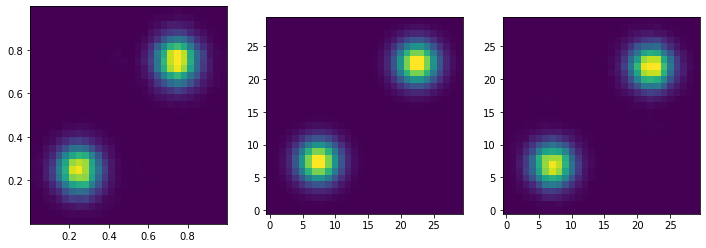

tensor(169.8775, device='cuda:7')

In [27]:
test_func_var(camel,40,1,True)
test_func_var(camel,40,1,True)
test_func_var(camel,40,1,True)

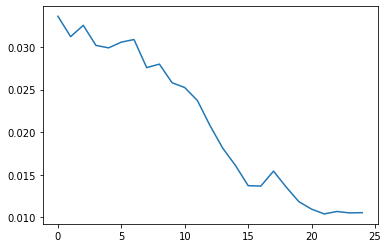

flat: 0.06357759237289429 with var 0.02787485346198082
model: 0.06252032518386841 with var 0.0063725002110004425
speed-up: 4.374241352081299




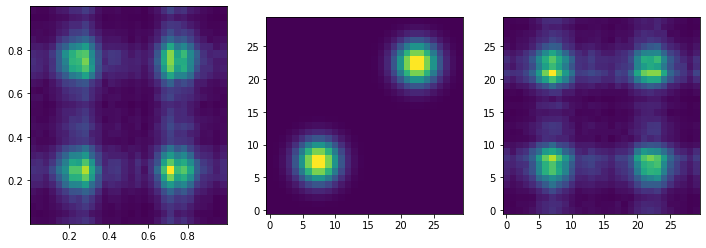

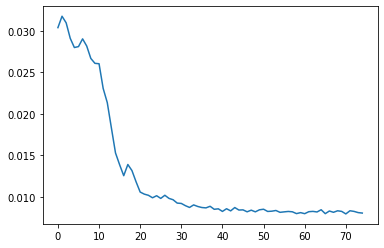

flat: 0.06264357268810272 with var 0.02717272751033306
model: 0.06240861117839813 with var 0.004193625878542662
speed-up: 6.4795308113098145




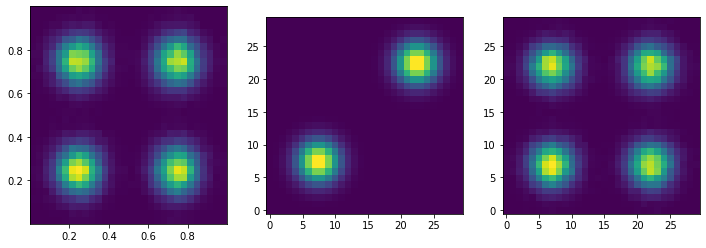

tensor(6.4795, device='cuda:7')

In [28]:
test_func_var(camel,1,5,True)
test_func_var(camel,1,15,True)

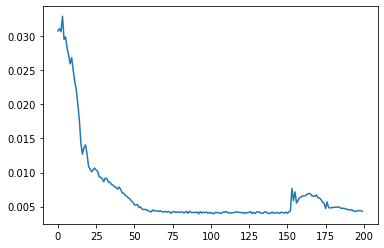

flat: 0.06294219940900803 with var 0.02758956514298916
model: 0.06287923455238342 with var 0.00042826024582609534
speed-up: 64.42243194580078




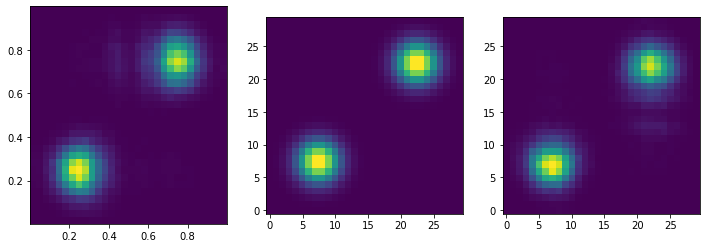

tensor(64.4224, device='cuda:7')

In [29]:
test_func_var(camel,1,40,True)

So for short times we're learning "VEGAS-style" but then we create "wrong" peaks

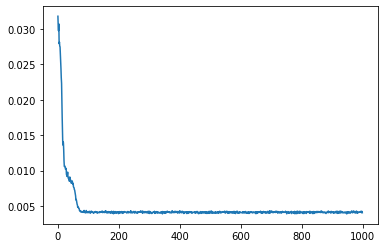

flat: 0.06334703415632248 with var 0.027709996327757835
model: 0.06276565790176392 with var 0.000154205146827735
speed-up: 179.69566345214844




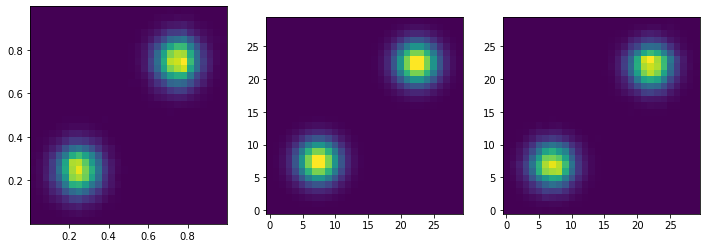

tensor(179.6957, device='cuda:7')

In [30]:
test_func_var(camel,1,200,True)

## Is it a problem with zero?

In [31]:
def nonzerocamel(reg):
    def camel(x):
        return reg+torch.exp(- torch.sum(((x-.25)/0.1)**2,dim=-1)  )+torch.exp(- torch.sum(((x-.75)/0.1)**2,dim=-1)  )
    return camel

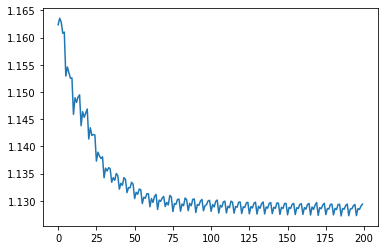

flat: 1.062822699546814 with var 0.02749008685350418
model: 1.062910556793213 with var 0.001561000244691968
speed-up: 17.610559463500977




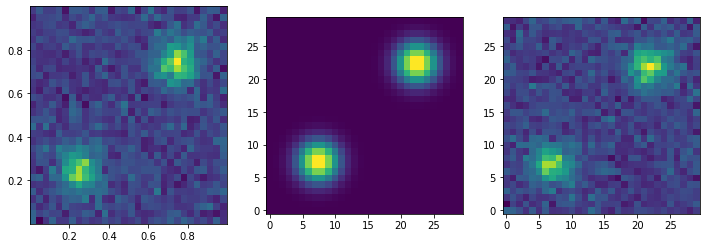

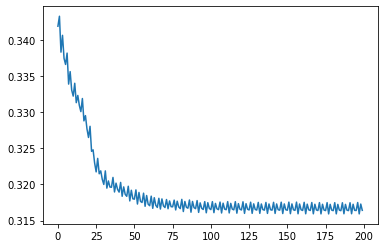

flat: 0.5622971653938293 with var 0.027077732607722282
model: 0.562746524810791 with var 0.0005080651608295739
speed-up: 53.2957878112793




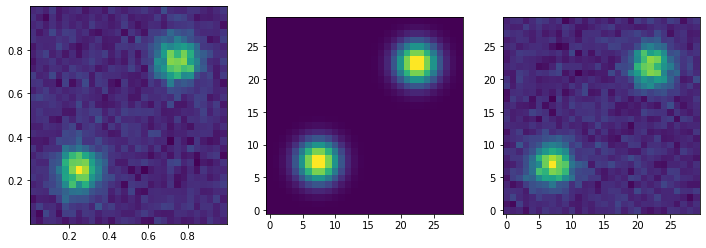

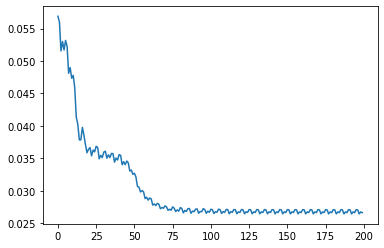

flat: 0.16236218810081482 with var 0.027217987924814224
model: 0.1627693772315979 with var 0.00019470929692033678
speed-up: 139.78781127929688




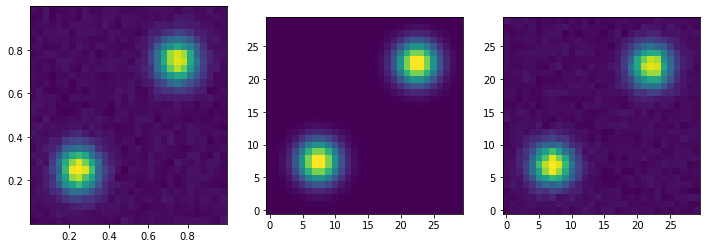

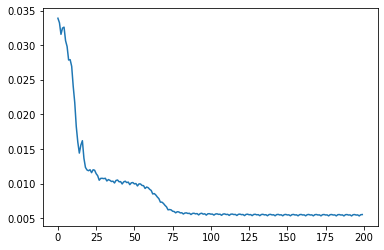

flat: 0.07223702222108841 with var 0.026920223608613014
model: 0.07274630665779114 with var 0.0001624568976694718
speed-up: 165.7068634033203




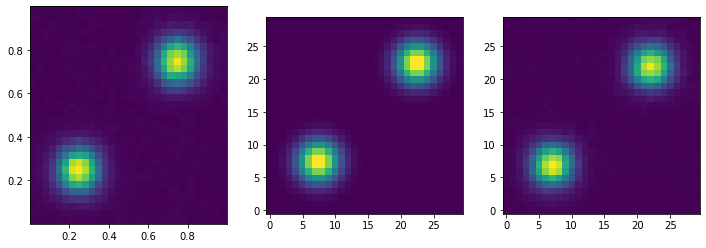

tensor(165.7069, device='cuda:7')

In [32]:
test_func_var(nonzerocamel(1.),40,1,True)
test_func_var(nonzerocamel(.5),40,1,True)
test_func_var(nonzerocamel(.1),40,1,True)
test_func_var(nonzerocamel(.01),40,1,True)

Yep, seems like it. Niklas is getting the opposite behavior, is it due to the training mode?

In [33]:
def wiggly(x):
    return torch.exp( - ( 2*x[:,1] -  (1+torch.cos(4*pi*x[:,0]))  )**2/0.3**2 )

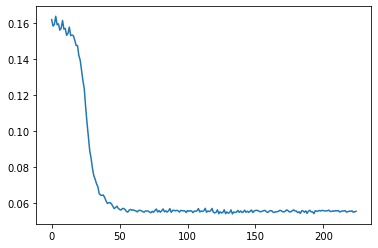

flat: 0.2210812270641327 with var 0.11324076354503632
model: 0.21948376297950745 with var 0.0068077207542955875
speed-up: 16.634166717529297




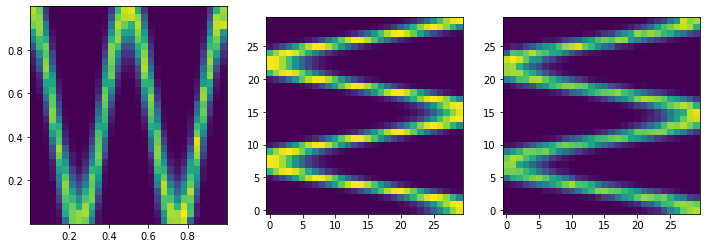

tensor(16.6342, device='cuda:7')

In [34]:
test_func_var(wiggly,3,15,True)

In [35]:
def circle_line(x):
    return torch.clamp(\
torch.exp( - 
    (
        ((x[:,0]-.5)**2 + (x[:,1]-.5)**2)**0.5 - 0.3
    )**2/0.05**2
    ) +\
torch.exp( -
    (
        x[:,0] - x[:,1]
    )**2/0.05**2
    )
    
                      ,0.,.9)


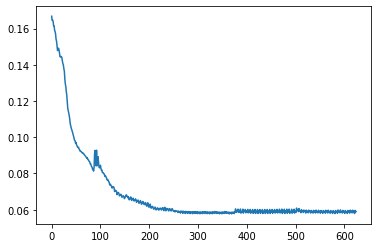

flat: 0.23783650994300842 with var 0.11018771678209305
model: 0.23745518922805786 with var 0.002596840960904956
speed-up: 42.43144607543945




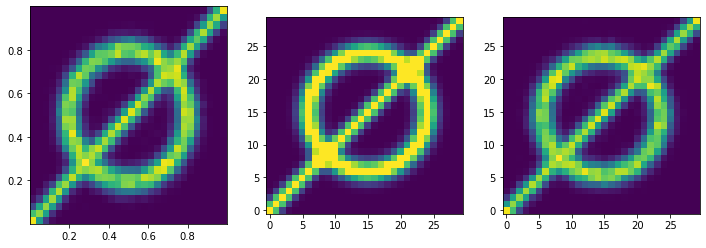

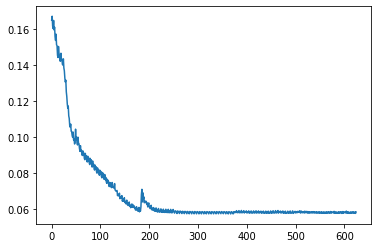

flat: 0.23652084171772003 with var 0.10959577560424805
model: 0.23740118741989136 with var 0.002489888109266758
speed-up: 44.0163459777832




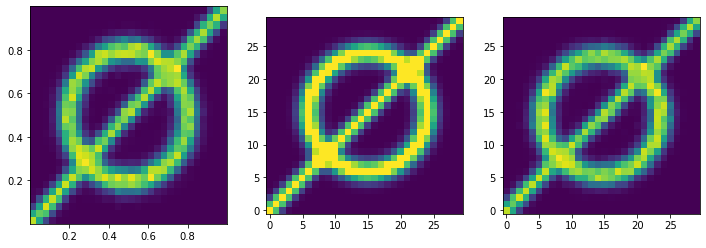

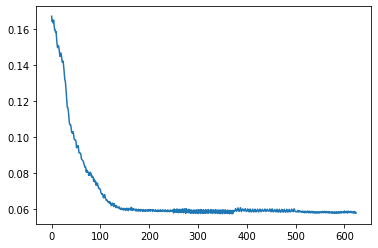

flat: 0.23742744326591492 with var 0.10977844148874283
model: 0.2372577041387558 with var 0.002406999934464693
speed-up: 45.607994079589844




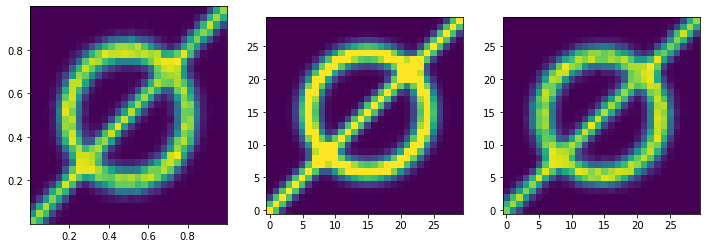

tensor(45.6080, device='cuda:7')

In [36]:
test_func_var(circle_line,25,5,True)
test_func_var(circle_line,25,5,True)
test_func_var(circle_line,25,5,True)

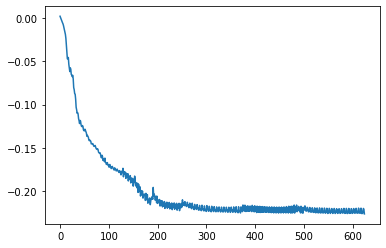

flat: 0.23689323663711548 with var 0.1099078580737114
model: 0.23717659711837769 with var 0.0029682095628231764
speed-up: 37.02833557128906




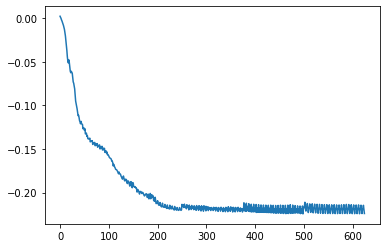

flat: 0.23744134604930878 with var 0.11014445126056671
model: 0.23753145337104797 with var 0.0027321733068674803
speed-up: 40.31385803222656




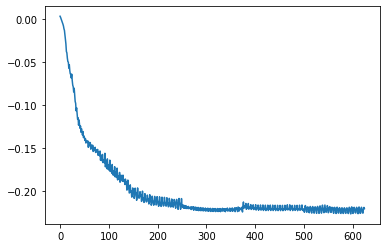

flat: 0.23699051141738892 with var 0.11020740121603012
model: 0.2370482087135315 with var 0.003034865250810981
speed-up: 36.31377029418945




In [37]:
test_func(circle_line,25,5)
test_func(circle_line,25,5)
test_func(circle_line,25,5)

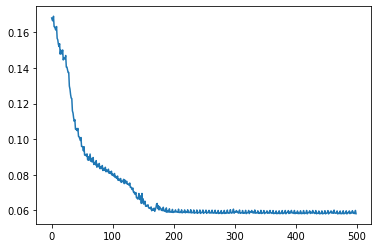

flat: 0.23893940448760986 with var 0.1103939637541771
model: 0.23711077868938446 with var 0.0023420106153935194
speed-up: 47.13640594482422




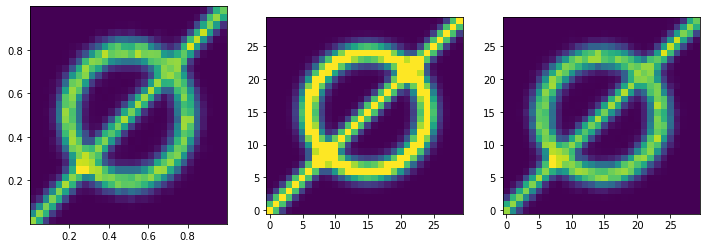

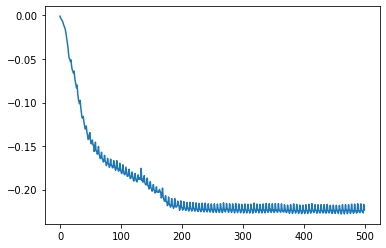

flat: 0.2388608306646347 with var 0.11056389659643173
model: 0.23754671216011047 with var 0.003180944826453924
speed-up: 34.75819396972656




In [38]:
test_func_var(circle_line,100,1,True)
test_func(circle_line,100)

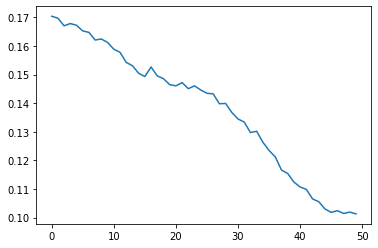

flat: 0.23710128664970398 with var 0.10988008230924606
model: 0.2370225042104721 with var 0.043196018785238266
speed-up: 2.543754816055298




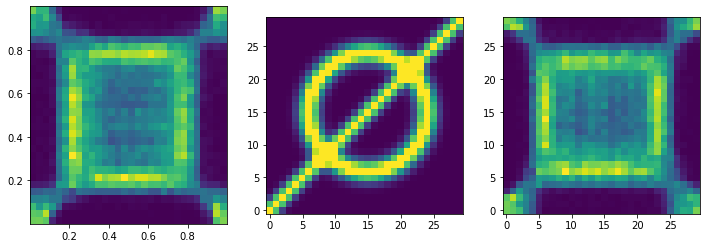

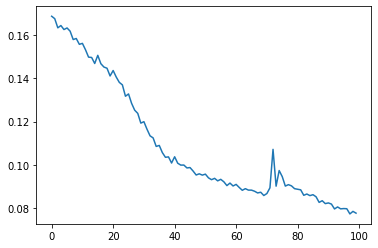

flat: 0.23653993010520935 with var 0.10963078588247299
model: 0.23708075284957886 with var 0.021193809807300568
speed-up: 5.172773838043213




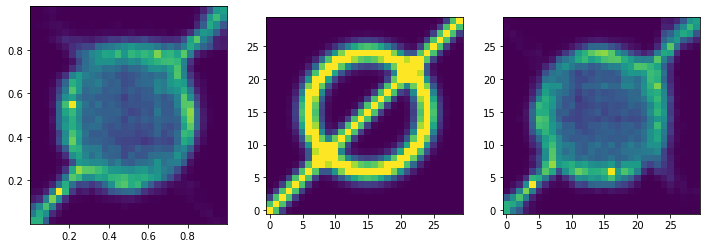

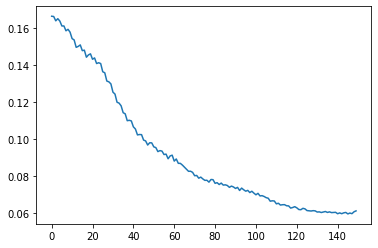

flat: 0.23714679479599 with var 0.10989394038915634
model: 0.23764684796333313 with var 0.004153289366513491
speed-up: 26.459495544433594




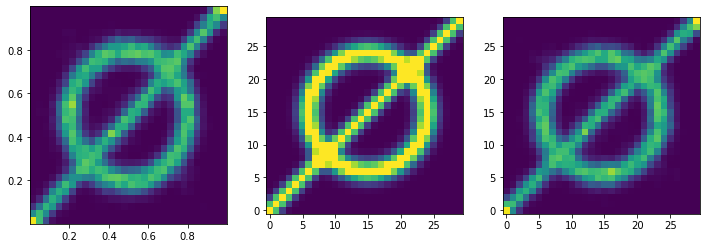

tensor(26.4595, device='cuda:7')

In [42]:
test_func_var(circle_line,10,1,True)
test_func_var(circle_line,20,1,True)
test_func_var(circle_line,30,1,True)